      surface  nombre_de_chambres           prix
0  106.611610                   4  647998.220921
1   61.475327                   4  420315.269829
2   54.953660                   4  402780.323319
3   90.644625                   2  517014.201281
4  109.141587                   2  604414.495371


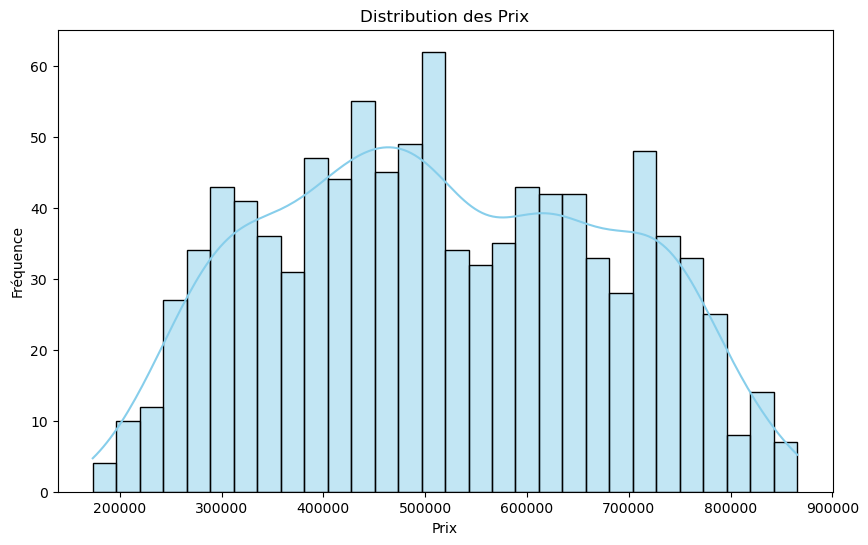

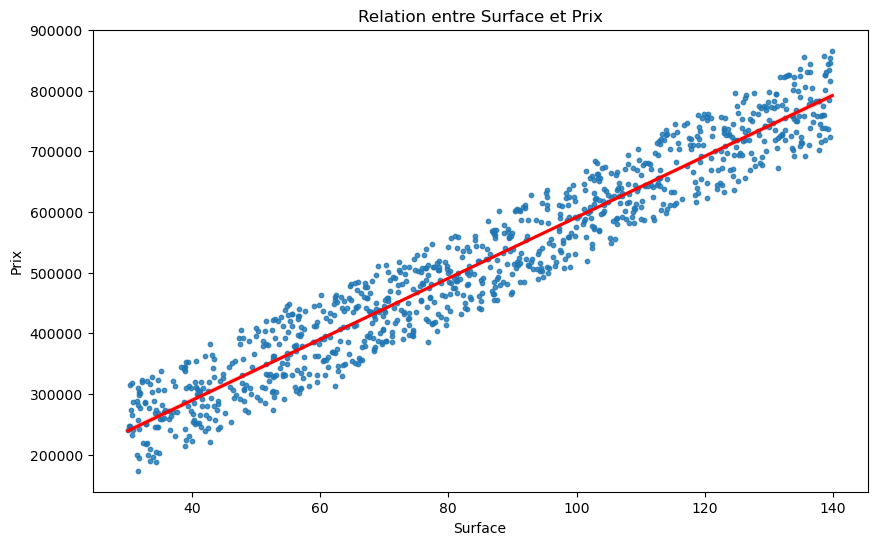

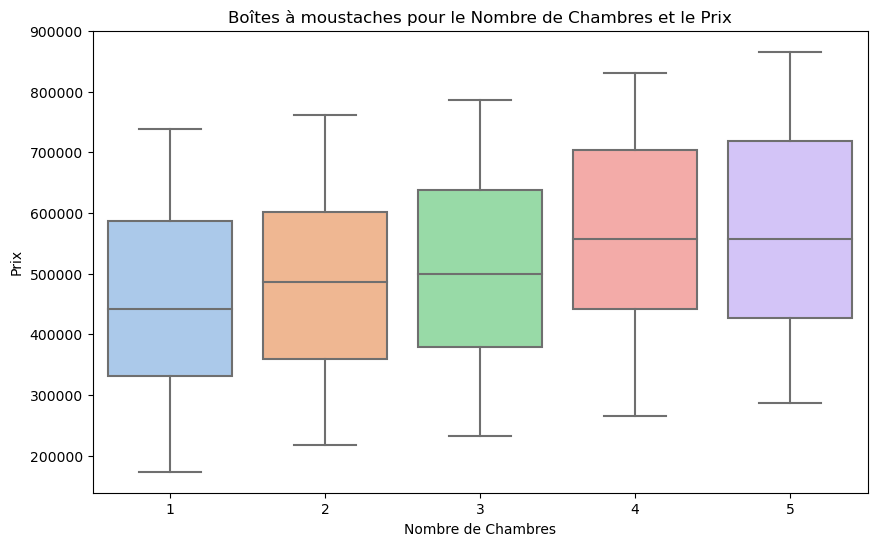

Mean Squared Error : 90831449.17995653
R-squared : 0.9964023219439552
Interception (b0) : -2141.3145841567894
Coefficients (b1, b2, ...) : [ 5019.98476695 30209.41146989]


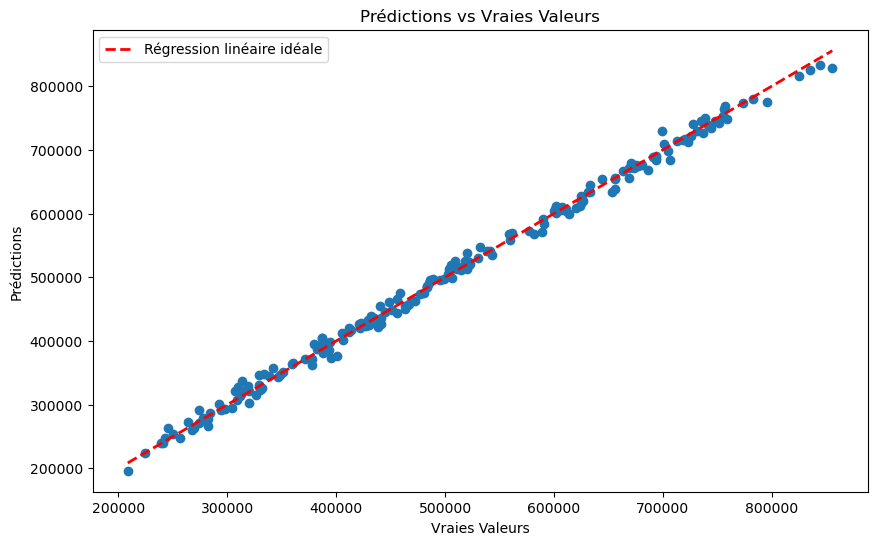

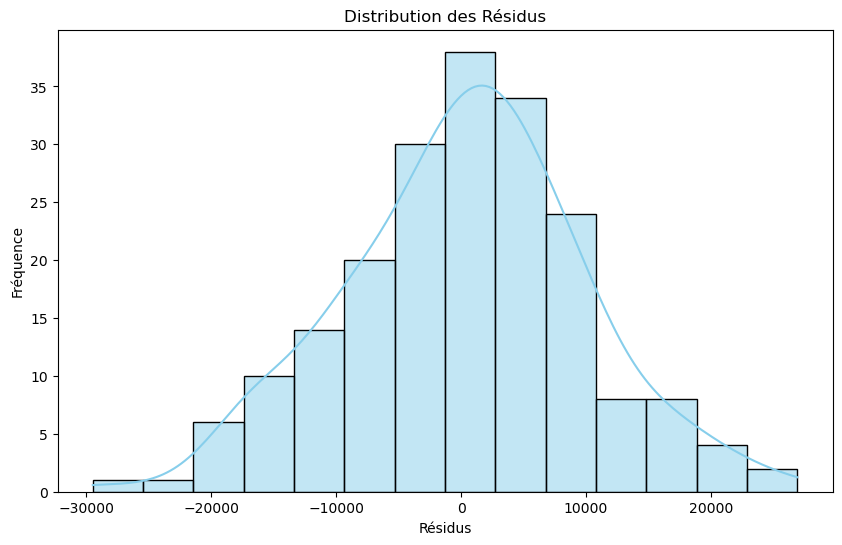

Mean Cross-Validated MSE : 94609186.08617833
Tableau des résultats dans l'intervalle de prix jugé intéressant :
     Nombre_De_Chambres    Surface  Vraies_Valeurs    Prix_Predit  \
521                   3  74.521343   472741.646778  462582.928793   
737                   2  53.055116   330597.122937  324613.379988   
660                   5  47.967146   391906.835769  389700.085235   
411                   1  66.602898   377836.123951  362413.629662   
513                   4  63.371881   440945.659327  436822.207282   

          Résidus  
521  10158.717985  
737   5983.742949  
660   2206.750534  
411  15422.494289  
513   4123.452045  


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Lire le CSV existant 
# data = pd.read_csv('maison.csv') CSV a prendre sur internet ou a faire sois meme

# Paramètres
np.random.seed(123)  # Pour faire des parametre aléatoire

# Générer des données fictives
num_samples = 1000
surface = np.random.uniform(30, 140, num_samples)  # Plage de surface entre 30 et 140 m^2
nombre_de_chambres = np.random.randint(1, 6, num_samples)  # Jusqu'à 5 chambres
prix = 5000 * surface + 30000 * nombre_de_chambres + np.random.normal(0, 10000, num_samples)  # Plafonné à un prix de 1 000 000 euros

# Créer un dataframe
data = pd.DataFrame({'surface': surface, 'nombre_de_chambres': nombre_de_chambres, 'prix': prix})

# Afficher les premières lignes du dataframe
print(data.head())

# Distribution des prix
plt.figure(figsize=(10, 6))
sns.histplot(data['prix'], bins=30, kde=True, color='skyblue')
plt.title('Distribution des Prix')
plt.xlabel('Prix')
plt.ylabel('Fréquence')
plt.show()

# Relation entre la surface et le prix avec une régression linéaire
plt.figure(figsize=(10, 6))
sns.regplot(x='surface', y='prix', data=data, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.title('Relation entre Surface et Prix')
plt.xlabel('Surface')
plt.ylabel('Prix')
plt.show()

# Boîtes à moustaches pour le nombre de chambres et le prix
plt.figure(figsize=(10, 6))
sns.boxplot(x='nombre_de_chambres', y='prix', data=data, palette='pastel')
plt.title('Boîtes à moustaches pour le Nombre de Chambres et le Prix')
plt.xlabel('Nombre de Chambres')
plt.ylabel('Prix')
plt.show()

# Nuage de points interactif
fig = px.scatter(data, x='surface', y='prix', color='nombre_de_chambres', size='prix',
                 hover_name='nombre_de_chambres', title='Nuage de Points Interactif', labels={'prix': 'Prix'})
fig.show()

# Préparation des données
X = data[['surface', 'nombre_de_chambres']]
y = data['prix']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construction et entraînement du modèle
# Initialiser le modèle de régression linéaire
model = LinearRegression()

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Faire des prédictions sur les données de test
y_pred = model.predict(X_test)

# Calculer les métriques d'évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Afficher les résultats
print(f'Mean Squared Error : {mse}')
print(f'R-squared : {r2}')

# Afficher l'interception (b0) et les coefficients (b1, b2, ...)
interception = model.intercept_
coefficients = model.coef_

print(f'Interception (b0) : {interception}')
print(f'Coefficients (b1, b2, ...) : {coefficients}')

# Visualisation des prédictions par rapport aux vraies valeurs
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Régression linéaire idéale')
plt.title('Prédictions vs Vraies Valeurs')
plt.xlabel('Vraies Valeurs')
plt.ylabel('Prédictions')
plt.legend()
plt.show()

# Calcul des résidus (différences entre les vraies valeurs et les prédictions)
residus = y_test - y_pred

# Visualisation des résidus
plt.figure(figsize=(10, 6))
sns.histplot(residus, kde=True, color='skyblue')
plt.title('Distribution des Résidus')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.show()

from sklearn.model_selection import cross_val_score

# Effectuer une validation croisée pour évaluer la performance du modèle
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
mean_mse_cv = -np.mean(cross_val_scores)

print(f'Mean Cross-Validated MSE : {mean_mse_cv}')

# Création du DataFrame resultats
resultats = pd.DataFrame({'Vraies_Valeurs': y_test, 'Prix_Predit': y_pred, 'Résidus': residus})

# Ajout des colonnes Nombre de chambres, Surface et autres informations à partir de X_test
resultats['Nombre_De_Chambres'] = X_test['nombre_de_chambres'].values
resultats['Surface'] = X_test['surface'].values

# Sélectionner les colonnes intéressantes pour l'affichage
colonnes_affichees = ['Nombre_De_Chambres', 'Surface', 'Vraies_Valeurs', 'Prix_Predit', 'Résidus']

# Définir l'intervalle de prix jugé intéressant (par exemple, entre 100000 et 500000 euros)
intervalle_interessant_min = 100000
intervalle_interessant_max = 500000

# Filtrer les résultats dans l'intervalle intéressant
resultats_interessants = resultats[(resultats['Prix_Predit'] >= intervalle_interessant_min) & (resultats['Prix_Predit'] <= intervalle_interessant_max)]

# Afficher le tableau avec les résultats intéressants
print("Tableau des résultats dans l'intervalle de prix jugé intéressant :")
print(resultats_interessants[colonnes_affichees].head(5))









Mean Squared Error : 142650653.11777404
R-squared : 0.9943498520717698


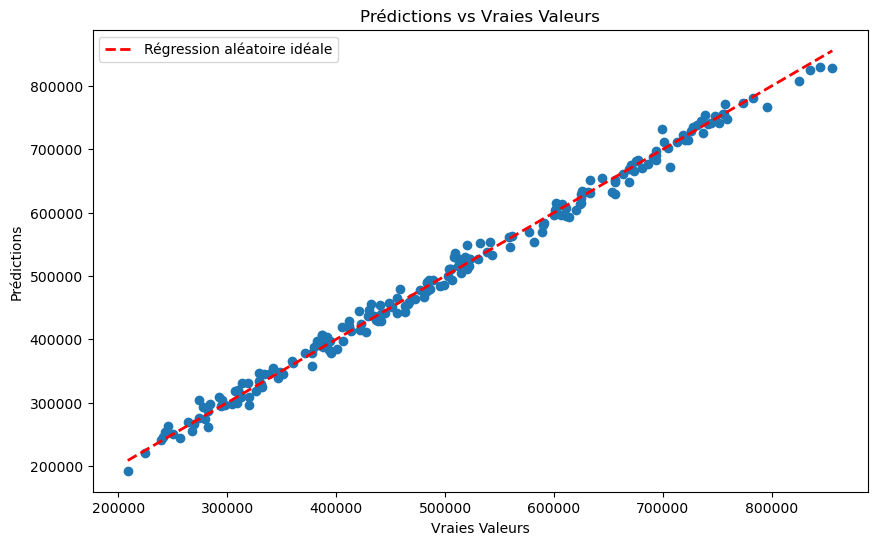

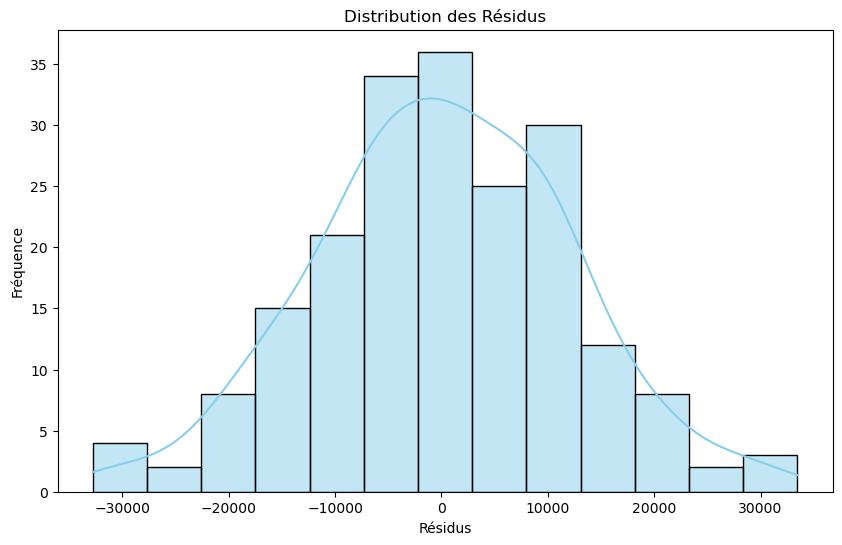

Mean Cross-Validated MSE : 43265477433.49913


In [7]:
#Modifications avec un autre type de modele
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Charger les données (commenter cette ligne lorsque tu auras un CSV)
# data = pd.read_csv('maison.csv')

# Paramètres
np.random.seed(123)

# Générer des données fictives (peut être remplacé par la lecture d'un fichier CSV)
num_samples = 1000
surface = np.random.uniform(30, 140, num_samples)
nombre_de_chambres = np.random.randint(1, 6, num_samples)
prix = 5000 * surface + 30000 * nombre_de_chambres + np.random.normal(0, 10000, num_samples)
data = pd.DataFrame({'surface': surface, 'nombre_de_chambres': nombre_de_chambres, 'prix': prix})

# Commentaire : Préparation des données
def prepare_data(data):
    X = data[['surface', 'nombre_de_chambres']]
    y = data['prix']
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = prepare_data(data)

# Commentaire : Construction et entraînement du modèle
def train_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

model = train_model(X_train, y_train)

# Commentaire : Évaluation du modèle
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error : {mse}')
    print(f'R-squared : {r2}')

evaluate_model(model, X_test, y_test)

# Commentaire : Visualisation des résultats
def visualize_results(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Régression aléatoire idéale')
    plt.title('Prédictions vs Vraies Valeurs')
    plt.xlabel('Vraies Valeurs')
    plt.ylabel('Prédictions')
    plt.legend()
    plt.show()

visualize_results(y_test, model.predict(X_test))

# Commentaire : Distribution des résidus
def visualize_residuals(y_test, y_pred):
    residus = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residus, kde=True, color='skyblue')
    plt.title('Distribution des Résidus')
    plt.xlabel('Résidus')
    plt.ylabel('Fréquence')
    plt.show()

visualize_residuals(y_test, model.predict(X_test))

# Commentaire : Validation croisée
def cross_validate(model, X, y):
    cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mean_mse_cv = -np.mean(cross_val_scores)
    print(f'Mean Cross-Validated MSE : {mean_mse_cv}')

cross_validate(model, X, y)
